In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/rl_robust_owc')

In [2]:
%matplotlib notebook
import os
import pickle
import numpy as np 
import matplotlib.pyplot as plt  
from itertools import product
from tqdm.notebook import trange
import functools
from time import time, sleep
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from utils.env_evaluate_functions import eval_actions
from utils.plot_functions import plot_s_animation, plot_k_array
from utils.clustering_functions import get_connectivity_dist_mat

from ressim_env import ResSimEnv_v0, ResSimEnv_v1
from model.ressim import Grid
from k_distributions.generate_k_channel import generate_domain_based_train_data, batch_generate

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1

env_dir = './env_data'
os.makedirs(env_dir, exist_ok=True)

# Single phase case

In [4]:
# domain properties
nx = 61
ny = 61
lx = 1200*0.3048 # 1200 ft
ly = 1200*0.3048 # 1200 ft
grid = Grid(nx=nx, ny=ny, lx=lx, ly=ly)

phi = 0.2*np.ones(grid.shape)
s_wir = 0.0
s_oir = 0.0

# fluid properties
mu_w = 3e-4 # 0.3 cp
mu_o = mu_w
mobility='linear'

# time steps
dt = 1
nstep = 25
terminal_step= 5 # total: 125 days

# initial conditions
ooip = grid.lx * grid.ly * phi[0,0] * (1 - s_wir - s_oir) # original oil in place
total_time = nstep*terminal_step*dt
fraction = 0.7
Q = fraction*ooip/total_time 
q = np.zeros(grid.shape)
q[::2,0] = Q/round(grid.nx/2)
q[::2,-1] = -Q/round(grid.nx/2)
s = np.ones(grid.shape)*s_wir

### permeability distribution

<IPython.core.display.Javascript object>


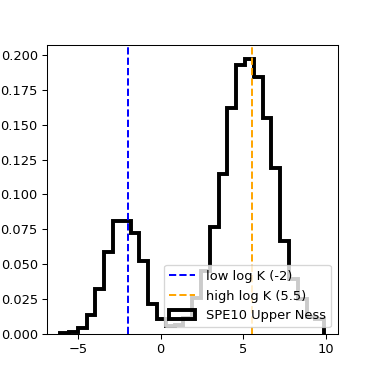

In [5]:
k = np.loadtxt(f'/data/ad181/RemoteDir/k_variability_in_ressim_env/SPE10_like_envs/spe10_ref_case/spe10_data/upperness_perm.csv', delimiter=',') 
m2_md_conv = 1.01325e+15
k = m2_md_conv*k
fig, axs = plt.subplots(1,1, figsize=(4,4) )
low_log_k = -2
high_log_k = 5.5

# generate random training and evaluation samples

k_train = batch_generate(nx=grid.nx, ny=grid.ny, lx=grid.lx, ly=grid.ly, 
                         channel_k=high_log_k, base_k=low_log_k, channel_width_range=(0.1,0.3), 
                         sample_size=9, seed=seed+10)

k_eval = batch_generate(nx=grid.nx, ny=grid.ny, lx=grid.lx, ly=grid.ly, 
                         channel_k=high_log_k, base_k=low_log_k, channel_width_range=(0.1,0.3), 
                         sample_size=16, seed=seed)

axs.hist(np.log(k.flatten()), density=True, histtype='step', bins=30, linestyle='solid', linewidth=3, color='black')
axs.axvline(low_log_k, linestyle='dashed', color='blue')
axs.axvline(high_log_k, linestyle='dashed', color='orange')
axs.legend([f'low log K ({low_log_k})', f'high log K ({high_log_k})', 'SPE10 Upper Ness'], loc='lower right')
fig.show()

In [6]:
# unit conversion 
md_m2_conv = 1/1.01325e+15
k_train = md_m2_conv*np.exp(k_train) 
k_eval = md_m2_conv*np.exp(k_eval)  

### simulation

simulation time: 2 seconds


<IPython.core.display.Javascript object>


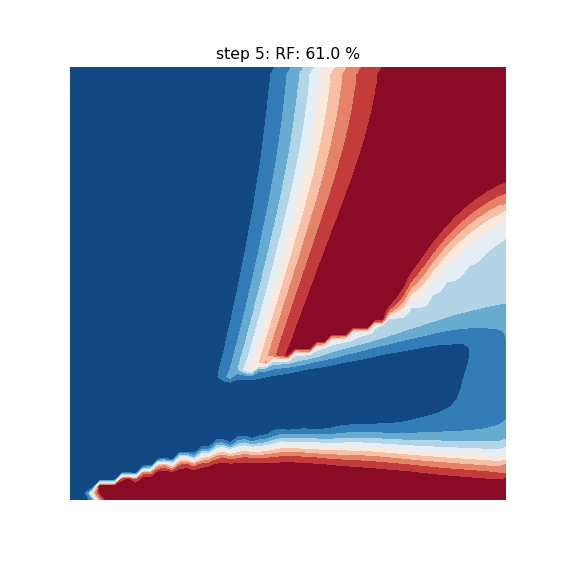

In [7]:
# Environments with constant permeability
index = 0 # from [0,1,...,8]
env = ResSimEnv_v1(grid, np.array([k_train[index]]), phi, s_wir, s_oir,  # domain properties
                   mu_w, mu_o, mobility,                                 # fluid properties
                   dt, nstep, terminal_step,                             # timesteps
                   q, s) 
actions_base = np.ones((env.terminal_step, env.action_space.shape[0]) )

before = time()
states, actions, rewards = eval_actions(env, actions_base)
print(f'simulation time: {round(time()-before)} seconds')
fig = plot_s_animation(states, actions, rewards, show_wells=False) 

## generate environment

In [8]:
env_train = ResSimEnv_v1(grid, k_train, phi, s_wir, s_oir,                     # domain properties
                         mu_w, mu_o, mobility,                                 # fluid properties
                         dt, nstep, terminal_step,                             # timesteps
                         q, s) 
    
env_eval = ResSimEnv_v1(grid, k_eval, phi, s_wir, s_oir,                      # domain properties
                        mu_w, mu_o, mobility,                                 # fluid properties
                        dt, nstep, terminal_step,                             # timesteps
                        q, s) 
    
env_list = []
for k in k_eval:
    env = ResSimEnv_v1(grid, np.array([k]), phi, s_wir, s_oir,  # domain properties
                          mu_w, mu_o, mobility,                 # fluid properties
                          dt, nstep, terminal_step,             # timesteps
                          q, s)                                 # initial conditions
    env.seed(seed)
    env_list.append(env)

## generate clustered samples

compute connectivity distances...



form distance matrix...


<IPython.core.display.Javascript object>


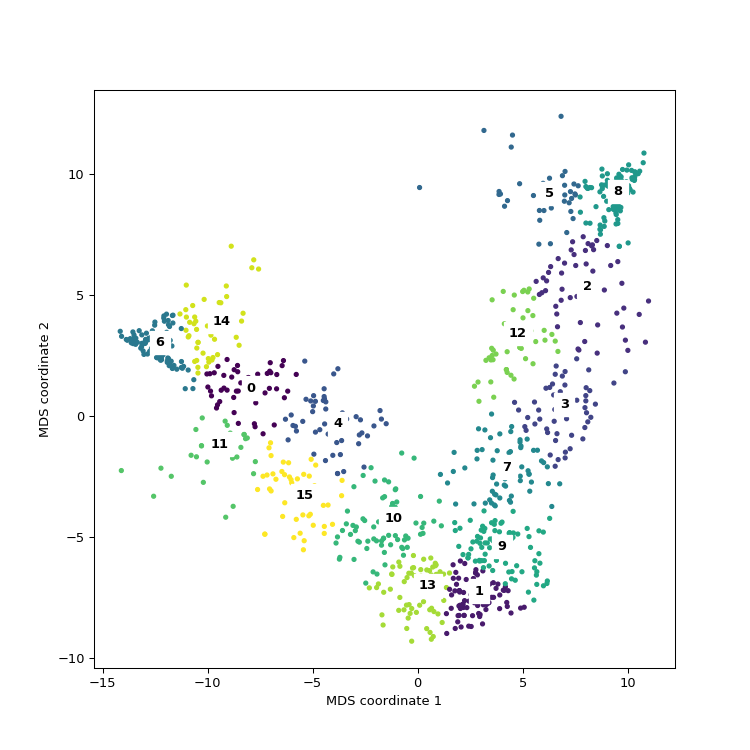

In [9]:
# generate N=1000 samples of the uncertainty distribution
n_samples=1000
k_samples_md = batch_generate(nx=env.grid.nx, ny=env.grid.ny, lx=env.grid.lx, ly=env.grid.ly, 
                         channel_k=high_log_k, base_k=low_log_k, channel_width_range=(0.1,0.3), 
                         sample_size=n_samples, seed=seed+10)
md_m2_conv = 1/1.01325e+15
k_samples = md_m2_conv*np.exp(k_samples_md) 

# locations x'' in equation 7
list_x, list_y = list(range(env.grid.nx)), list(range(env.grid.ny))
x,y = np.meshgrid(list_x[::15], list_y[::15])
x_loc, y_loc = x.ravel(), y.ravel()

# generate the clustering using MDS data
dist_matrix = get_connectivity_dist_mat(k_samples, env, x_loc, y_loc)
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=seed)
X_transformed = embedding.fit_transform(dist_matrix)

# number of clusters l=16
clusters = 16
km = KMeans(n_clusters=clusters, random_state=seed)
y_pred = km.fit_predict(X_transformed)
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, X_transformed)

plt.figure(figsize=(8,8))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_pred, marker='.')
for i, idx in enumerate(closest):
    plt.text(X_transformed[idx, 0], X_transformed[idx, 1], str(i), backgroundcolor='white', fontweight='bold')
plt.xlabel('MDS coordinate 1')
plt.ylabel('MDS coordinate 2')
plt.show()

## generate clustered training and evaluation samples

In [10]:
# training samples chosen from cluster centers
k_train_clustered = k_samples_md[closest]

# evaluations samples chosen randomly from each cluster
labels = km.labels_
k_clusters = []
for n in range(clusters):
    indices = np.where(labels==n)[0]
    ks = []
    for ind in indices:
        ks.append(k_samples_md[ind])
    k_clusters.append(ks)

k_eval_clustered = []
for k in k_clusters:
    mid_ind=int(len(k)/2) # choose k which is in the middle of each cluster array, for reproducibility
    k_eval_clustered.append(k[mid_ind])
k_eval_clustered = np.array(k_eval_clustered)


# save clustered samples
np.save(env_dir+'/k_log_md_train_clustered.npy', k_train_clustered)
np.save(env_dir+'/k_log_md_eval_clustered.npy', k_eval_clustered)

<IPython.core.display.Javascript object>


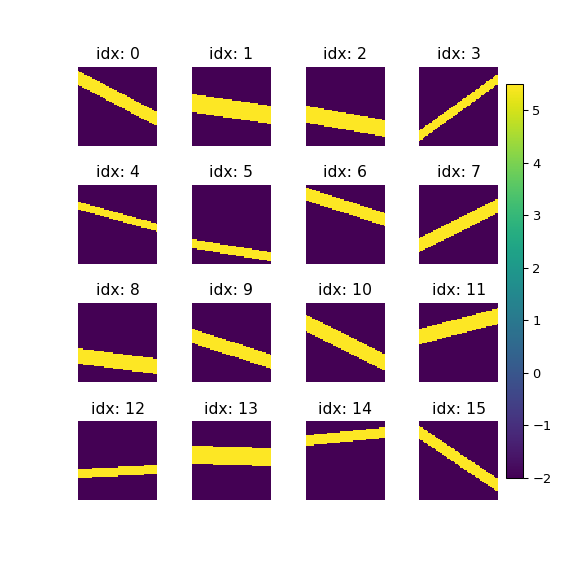

<IPython.core.display.Javascript object>


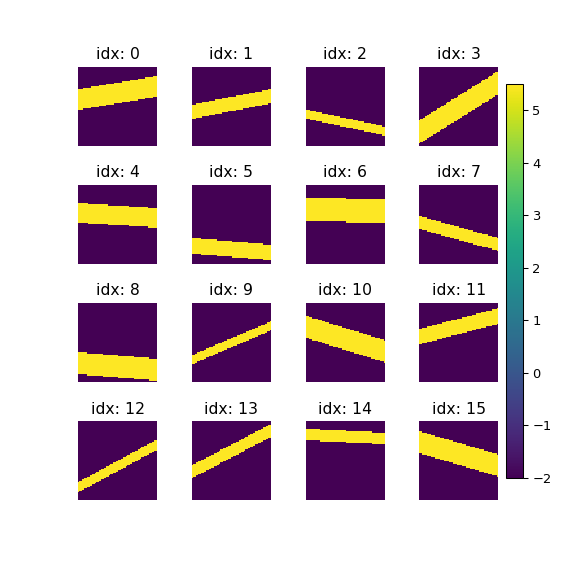

In [11]:
fig = plot_k_array(k_train_clustered,q=None, cols=int(np.sqrt(clusters)), rows=int(np.sqrt(clusters)))
fig = plot_k_array(k_eval_clustered,q=None, cols=int(np.sqrt(clusters)), rows=int(np.sqrt(clusters)))

## set clustered samples to the generated environements 

In [12]:
k_train_clustered = md_m2_conv*np.exp(k_train_clustered)
k_eval_clustered = md_m2_conv*np.exp(k_eval_clustered)

env_train.set_k(k_train_clustered)
env_eval.set_k(k_eval_clustered)

for i,k in enumerate(k_eval_clustered):
    env_list[i].set_k(np.array([k]))

### save environments

In [13]:
with open(env_dir+'/env_train.pkl', 'wb') as output:
    pickle.dump(env_train, output, pickle.HIGHEST_PROTOCOL)
    
with open(env_dir+'/env_eval.pkl', 'wb') as output:
    pickle.dump(env_eval, output, pickle.HIGHEST_PROTOCOL) 

with open(env_dir+'/env_list_eval.pkl', 'wb') as output:
    pickle.dump(env_list, output, pickle.HIGHEST_PROTOCOL)